## Upsell 모델 remodeling

### 목적
- 최신 데이터 반영
 
### 모델링
- 기존과 동일한 feature, preprocessing

In [149]:
import lightgbm as lgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive


from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data/'

In [3]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [4]:
def next_month(ym):
    next_month = datetime.strptime(ym, '%Y%m') + relativedelta(months=1)
    return datetime.strftime(next_month, '%Y%m')

### load data

In [5]:
df_mart06 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201906.pkl'))
df_mart07 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201907.pkl'))

In [6]:
df_mart06.shape, df_mart07.shape

((18620965, 81), (18612165, 81))

## modeling

In [140]:
# make train data
result = make_train_data(df_mart07)

trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']

val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

feature_cols = list(x_trn.columns)

lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

make_train_data +++
label/sample:  0.2
sample/total:  0.13230835853862247
make_data_for_modeling---


In [141]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'num_threads': 40,
}

In [142]:
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=5000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.772123	valid_1's auc: 0.771126
[100]	training's auc: 0.781651	valid_1's auc: 0.780299
[150]	training's auc: 0.786176	valid_1's auc: 0.7844
[200]	training's auc: 0.78912	valid_1's auc: 0.786998
[250]	training's auc: 0.791104	valid_1's auc: 0.788607
[300]	training's auc: 0.792488	valid_1's auc: 0.789618
[350]	training's auc: 0.793731	valid_1's auc: 0.790494
[400]	training's auc: 0.794619	valid_1's auc: 0.790949
[450]	training's auc: 0.795479	valid_1's auc: 0.791399
[500]	training's auc: 0.796204	valid_1's auc: 0.791694
[550]	training's auc: 0.796875	valid_1's auc: 0.791947
[600]	training's auc: 0.797547	valid_1's auc: 0.792222
[650]	training's auc: 0.798245	valid_1's auc: 0.792526
[700]	training's auc: 0.798875	valid_1's auc: 0.792759
[750]	training's auc: 0.799442	valid_1's auc: 0.792929
[800]	training's auc: 0.800037	valid_1's auc: 0.793133
[850]	training's auc: 0.800631	valid_1's auc: 0.793348
[900]	

## evaluate

In [143]:
test_result = make_test_data(df_mart06)
x_test = test_result['x']
y_test = test_result['y']

        acc    recall  precision  f1_score       auc
0  0.655336  0.748635   0.049252  0.092423  0.767967
         pred: 1   pred: 0
true: 1   326786    109723
true: 0  6308254  11876202


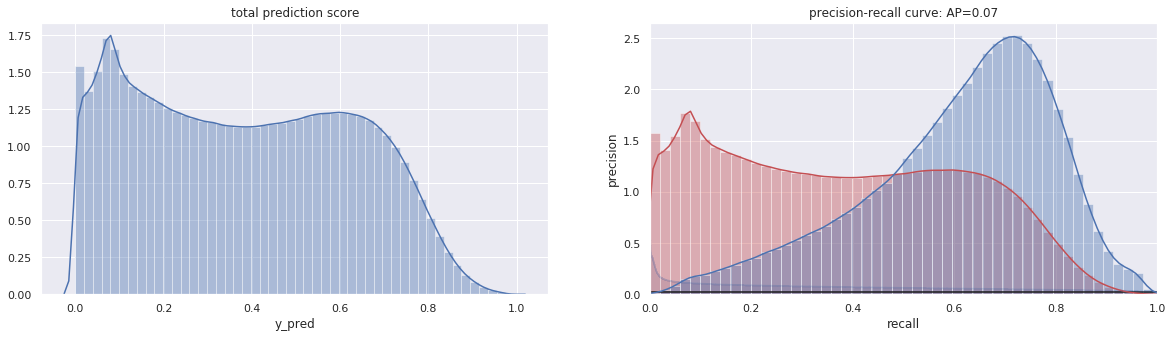

In [144]:
eval_result = evaluate(x_test[feature_cols], y_test.label.values, clf, clf_name='lgb')

## process for offline test

In [20]:
from item_reco_test_binary_post import OfflineTest4Binary

In [21]:
ot4b = OfflineTest4Binary(
    reco_type='upsell',
    test_ym='201906',
    model=clf,
    model_name='dominic_lgbm_07_20190905',
    feature_cols=clf.feature_name()
)

init +++
reco_type:  upsell
prod_id:  RC00000001
prod_nm:  요금제업셀가망
test_ym:  201906
model_name:  dominic_lgbm_07_20190905
feature_cols:  ['sex_cd', 'age', 'svc_gr', 'mng_nice_cb_scr', 'mng_nice_cb_grd', 'svc_scrb_period', 'last_equip_period', 'bas_fee_amt', 'bas_ofr_data_gb', 'eqp_out_prc', 'allot_prn_amt', 'pmth_inv_bamt', 'family_yn', 'family_small_yn', 'twld_visit_cnt_bf_m0', 'twld_visit_cnt_bf_m1', 'twld_visit_cnt_bf_m2', 'avg_twld_visit_cnt', 'twld_fee_visit_cnt_bf_m0', 'twld_fee_visit_cnt_bf_m1', 'twld_fee_visit_cnt_bf_m2', 'avg_twld_fee_visit_cnt', 'ansim_yn', 'ref_data_usage_in_gb_bf_m0', 'ref_data_usage_in_gb_bf_m1', 'ref_data_usage_in_gb_bf_m2', 'data_usage_in_gb_bf_m0', 'data_usage_in_gb_bf_m1', 'data_usage_in_gb_bf_m2', 'avg_data_usage_in_gb', 'overage_bf0', 'overage_bf1', 'overage_bf2', 'copn_data_u1_yn_bf_m0', 'copn_data_u1_yn_bf_m1', 'copn_data_u1_yn_bf_m2', 'data_gift_send_yn_bf_m0', 'data_gift_send_yn_bf_m1', 'data_gift_send_yn_bf_m2', 'data_gift_recv_yn_bf_m0', 'data_

In [22]:
ot4b.one_shot(df_mart06)

one_shot +++
submit_to_item_reco_test +++
load_to_comm_table +++
load to dumbo table +++
2019-09-05 16:09:22,020 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_test_upsell (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, ym string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-09-05 16:09:22,038 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-09-05 16:10:59,844 - YE_HIVE - INFO - Loading data to HDFS... 
2019-09-05 16:11:16,263 - YE_HIVE - INFO - Loading to table dumbo.item_reco_test_upsell is done
insert to comm table +++
2019-09-05 16:14:04,021 - YE_HIVE - INFO - Query '
            INSERT  OVERWRITE TABLE comm.item_reco_test PARTITION (reco_type, model, ym)
            SELECT  *
            FROM    dumbo.item_reco_test_upsell
        ' is done
drop dumbo table +++
2019-09-05 16:14:04,817 - YE_HIVE - INFO - Query 'dr

## Interpretable ML
- 서비스 나갈만한 모델인가?
- 모델이 어떤 특성으로 회선들을 예측하는지 이해해보자
- 그 방식이 resonable 한가?
    - 이상하다면?? -> todo_list를 만들고 추후에 변경

## How? & What?

1. Global interpretability
    - 전체적으로 봤을 때, 각각의 feature가 model output에 얼마나 영향을 미치는지? -> feature importance
    ex) 비싼 요금제를 쓰는 고객들이 5g 단말기를 사는 경향이 있다
2. Local interpretability
    - 개별 data point에 대한 model output 산출 이유
    ex) 해당 고객이 5g 단말기 살 가능성이 높은 이유는, '가입한지 2년이 됐고 이전 요금제가 비싸고 옥수수에 가입했기 때문'이다.



### model feature importance

In [103]:
pd.DataFrame({'feature': clf.feature_name(), 'importance': clf.feature_importance()}).sort_values('importance', ascending=False).head(50)

feature  importance
6            last_equip_period        5617
1                          age        4746
5              svc_scrb_period        3240
45            avg_chg_duration        3163
3              mng_nice_cb_scr        3024
53            data_usage_ratio        2975
7                  bas_fee_amt        2910
44     avg_subscription_period        2832
54  bf_m6_data_usage_ratio_avg        2708
46             real_arpu_bf_m1        2625
10               allot_prn_amt        2295
8              bas_ofr_data_gb        2223
48             real_arpu_bf_m3        2212
26      data_usage_in_gb_bf_m0        2127
47             real_arpu_bf_m2        1980
11               pmth_inv_bamt        1970
27      data_usage_in_gb_bf_m1        1898
28      data_usage_in_gb_bf_m2        1883
49               real_avg_arpu        1767
29        avg_data_usage_in_gb        1503
51  bf_m6_sum_data_usage_in_gb        1479
52  bf_m6_avg_data_usage_in_gb        1234
43             avg_mbr_use_cnt        1196
78                     channel         719
57           copn_left_cnt_bf0         633
30                 overage_bf0         599
17          avg_twld_visit_cnt         595
4              mng_nice_cb_grd         546
12                   family_yn         534
59           copn_left_cnt_bf2         506
16        twld_visit_cnt_bf_m2         478
32                 overage_bf2         433
50           bf_m3_fee_chg_cnt         426
55   bf_m6_data_over_usage_cnt         421
31                 overage_bf1         421
0                       sex_cd         405
69          mth_cnsl_cnt_bf_m0         400
2                       svc_gr         372
58           copn_left_cnt_bf1         359
71          mth_cnsl_cnt_bf_m2         325
15        twld_visit_cnt_bf_m1         320
70          mth_cnsl_cnt_bf_m1         303
25  ref_data_usage_in_gb_bf_m2         302
24  ref_data_usage_in_gb_bf_m1         278
75    simpl_ref_cnsl_cnt_bf_m0         255
77    simpl_ref_cnsl_cnt_bf_m2         250
76    simpl_ref_cnsl_cnt_bf_m1         222
13             family_small_yn         219
22                    ansim_yn         215
42                  sec_dev_yn         208

- top 20 살펴보기
- label 별 분포

In [96]:
top20_cols = list(pd.DataFrame({'feature': clf.feature_name(), 'importance': clf.feature_importance()}).sort_values('importance', ascending=False).head(20).feature)

In [95]:
from eda_tools import numeric_eda_plot, categorical_eda_plot

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 100000, 1: 100000}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



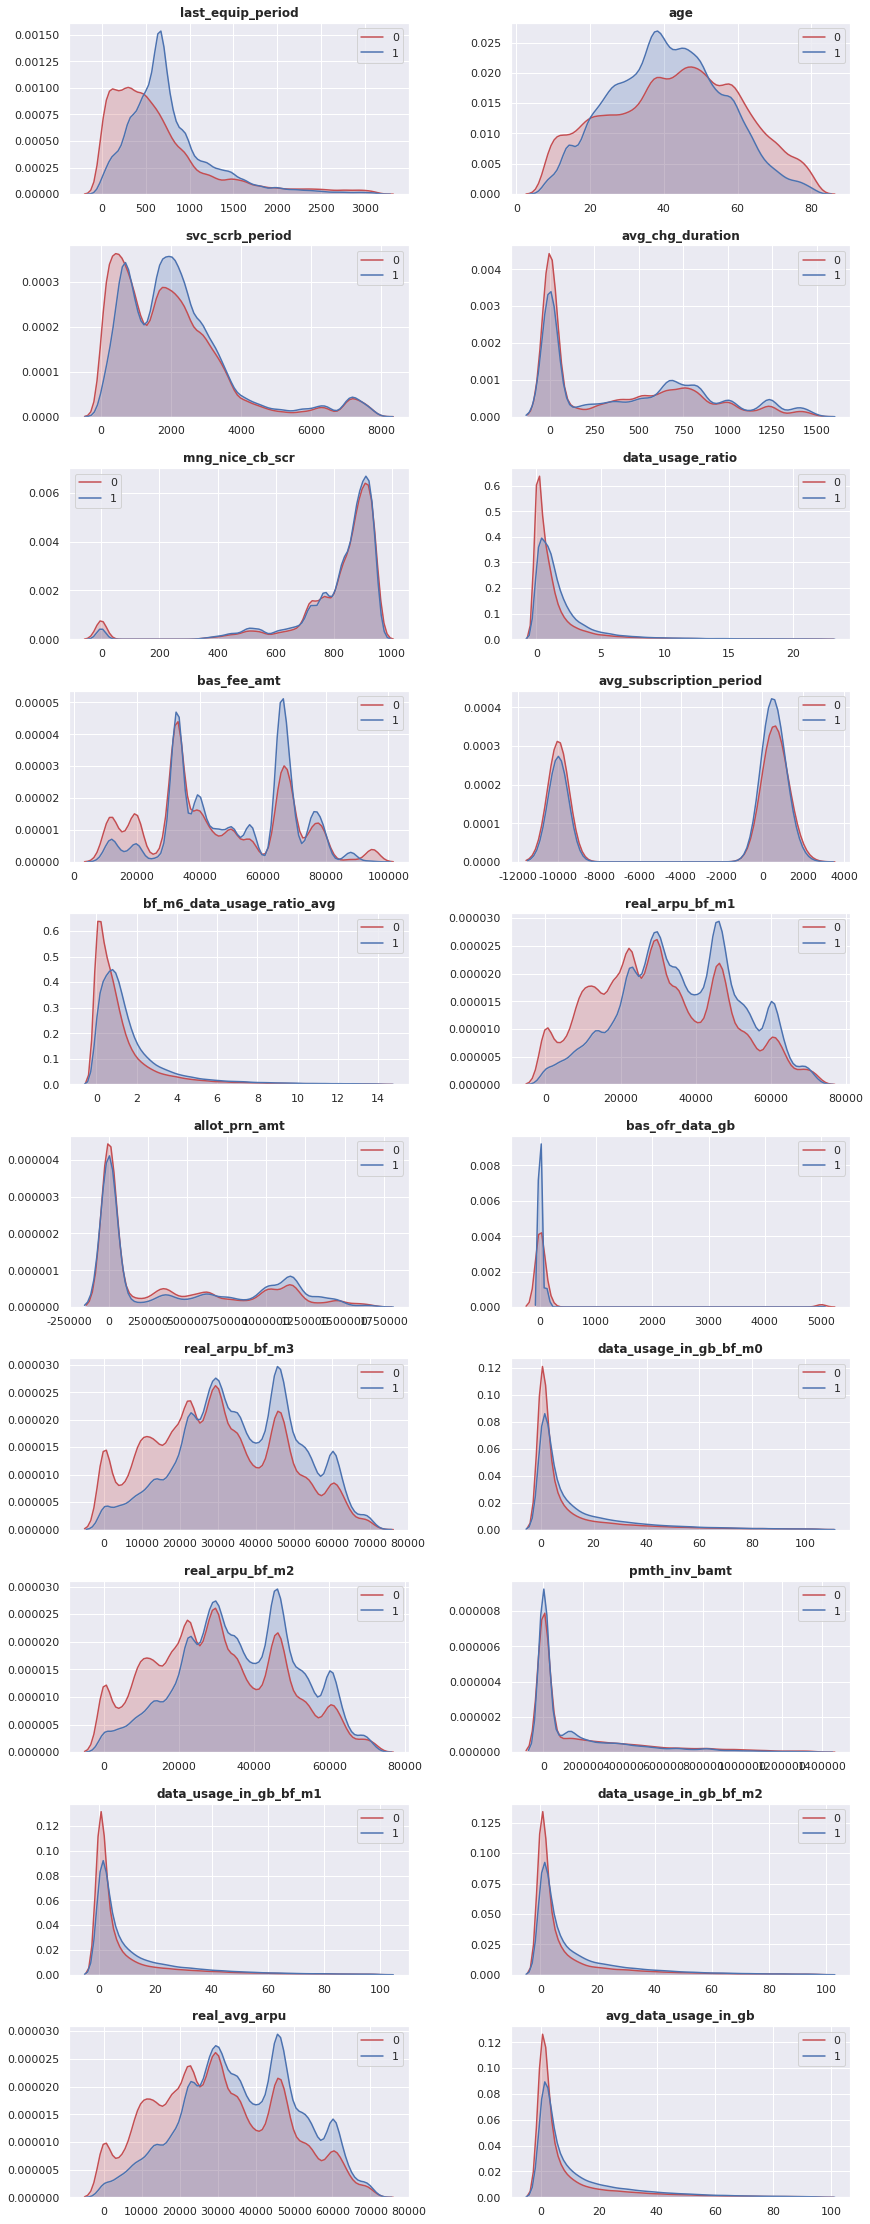

In [99]:
numeric_eda_plot(df_mart07_new, top20_cols, 'label', n_samples=100000)

In [126]:
for col in top20_cols:
    if col in ['age', 'avg_chg_duration', 'avg_subscription_period', 'allot_prn_amt', 'pmth_inv_bamt']:
        continue
    print('='*50)
    print('col: ', col)
    print('label ratio: ', df_mart07_new[df_mart07_new[col]==0].label.sum()/df_mart07_new[df_mart07_new[col]==0].shape[0])
    print('cnt: ', df_mart07_new[df_mart07_new[col]==0].shape[0])
    
    zero_dict[col] = list(df_mart07_new[df_mart07_new[col]==0].svc_mgmt_num.values)

col:  last_equip_period
label ratio:  0.007892997394922042
cnt:  25719
col:  svc_scrb_period
label ratio:  0.011572114027660174
cnt:  10629
col:  mng_nice_cb_scr
label ratio:  0.009375046688479525
cnt:  133866
col:  data_usage_ratio
label ratio:  0.009066056228212653
cnt:  2143159
col:  bas_fee_amt
label ratio:  0.017241379310344827
cnt:  58
col:  bf_m6_data_usage_ratio_avg
label ratio:  0.008479918731110207
cnt:  1943179
col:  real_arpu_bf_m1
label ratio:  0.005146029413803141
cnt:  577144
col:  bas_ofr_data_gb
label ratio:  nan
cnt:  0
col:  real_arpu_bf_m3
label ratio:  0.0058829192824963236
cnt:  903633
col:  data_usage_in_gb_bf_m0
label ratio:  0.009066056228212653
cnt:  2143159
col:  real_arpu_bf_m2
label ratio:  0.00567439301189903
cnt:  726950
col:  data_usage_in_gb_bf_m1
label ratio:  0.009263414031843739
cnt:  2324413
col:  data_usage_in_gb_bf_m2
label ratio:  0.00893543121833965
cnt:  2509448
col:  real_avg_arpu
label ratio:  0.004809306276580552
cnt:  539163
col:  avg_data_

### 해석
- 데이터 관련 feature가 0인 회선이 상당히 많음 -> 250만
- 대부분이 신규 고객
- 그런데 아닌 고객들도 있음 -> 확인 필요
- + 맞춤형, 함께쓰기 요금제 외에도 bas_ofr_data_gb 값이 0인 요금제가 있음 -> 뉴실버, 팅 등 

In [172]:
"""
select b.prod_id, b.prod_nm, count(1)
from comm.mmkt_svc_bas_f a
left join (
    SELECT  prod_id
    ,       prod_nm
    ,       if(bas_ofr_data_qty_val = '#', cast(bas_ofr_data_gb_qty_val as double), cast(bas_ofr_data_qty_val as int)/1024) as bas_ofr_data_gb_qty_val 
    from    comm.td_zprd_prod
    where   svc_prod_cd = 1 
) b on a.fee_prod_id = b.prod_id
where a.ym = '201907'
and b.bas_ofr_data_gb_qty_val is null
and prod_nm not like '%함께쓰기%' 
and prod_nm not like '%맞춤형%'
and fee_prod_id not in ('NA00006405','NA00006404','NA00006539','NA00003128','NA00002502','NA00005959',
                        'NA00003127','NA00002501','NA00003126','NA00002708','NA00003125','NA00002500','NA00002997')
group by b.prod_id, b.prod_nm
;
"""

"\nselect b.prod_id, b.prod_nm, count(1)\nfrom comm.mmkt_svc_bas_f a\nleft join (\n    SELECT  prod_id\n    ,       prod_nm\n    ,       if(bas_ofr_data_qty_val = '#', cast(bas_ofr_data_gb_qty_val as double), cast(bas_ofr_data_qty_val as int)/1024) as bas_ofr_data_gb_qty_val \n    from    comm.td_zprd_prod\n    where   svc_prod_cd = 1 \n) b on a.fee_prod_id = b.prod_id\nwhere a.ym = '201907'\nand b.bas_ofr_data_gb_qty_val is null\nand prod_nm not like '%함께쓰기%' \nand prod_nm not like '%맞춤형%'\nand fee_prod_id not in ('NA00006405','NA00006404','NA00006539','NA00003128','NA00002502','NA00005959',\n                        'NA00003127','NA00002501','NA00003126','NA00002708','NA00003125','NA00002500','NA00002997')\ngroup by b.prod_id, b.prod_nm\n;\n"

## shap value

In [30]:
from shap_tools import ShapModule

In [31]:
sm = ShapModule(df_mart07_new, clf, feature_cols, 'svc_mgmt_num', 'label')
sm.calculate_shap_value()

In [153]:
top20_cols

['last_equip_period',
 'age',
 'svc_scrb_period',
 'avg_chg_duration',
 'mng_nice_cb_scr',
 'data_usage_ratio',
 'bas_fee_amt',
 'avg_subscription_period',
 'bf_m6_data_usage_ratio_avg',
 'real_arpu_bf_m1',
 'allot_prn_amt',
 'bas_ofr_data_gb',
 'real_arpu_bf_m3',
 'data_usage_in_gb_bf_m0',
 'real_arpu_bf_m2',
 'pmth_inv_bamt',
 'data_usage_in_gb_bf_m1',
 'data_usage_in_gb_bf_m2',
 'real_avg_arpu',
 'avg_data_usage_in_gb']

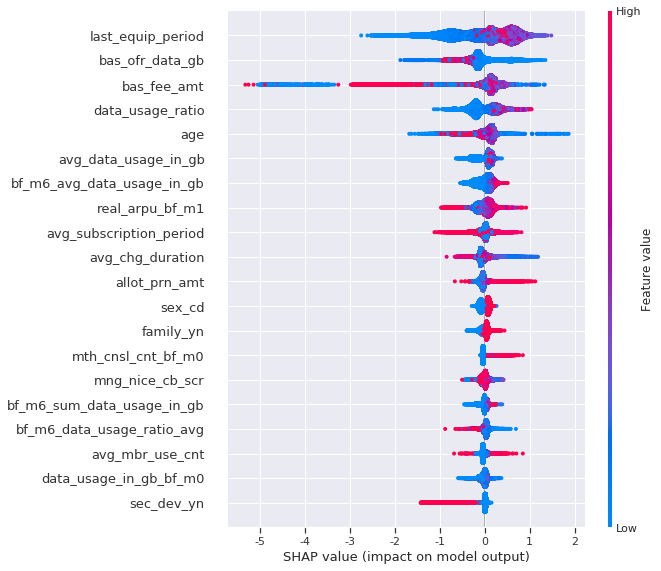

In [152]:
sm.summary_plot(max_display=20)

- allot_prn_amt, sex_cd, family_yn, mth_cnsl_cnt_bf_m0, avg_mbr_use_cnt, sexc_dev_yn 등이 model feature importance와 다름
- categorical feature가 더 있는 점이 흥미로움

In [56]:
svc_mgmt_num = '1032341110'
single_shap_value = sm.explainer.shap_values(sm.df[sm.feature_cols].loc[[svc_mgmt_num], :])
shap.force_plot(sm.explainer.expected_value, single_shap_value, 
                df_mart07_new[df_mart07_new['svc_mgmt_num']==svc_mgmt_num][sm.feature_cols], sm.feature_cols, out_names=str(svc_mgmt_num))

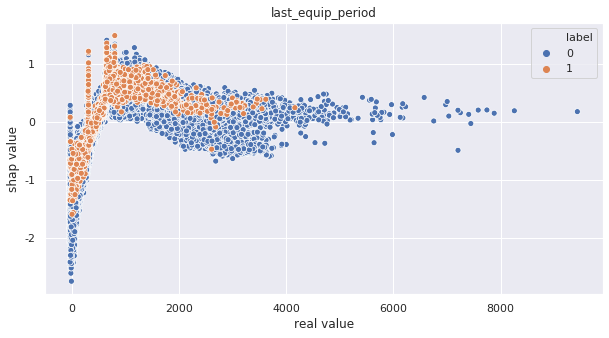

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



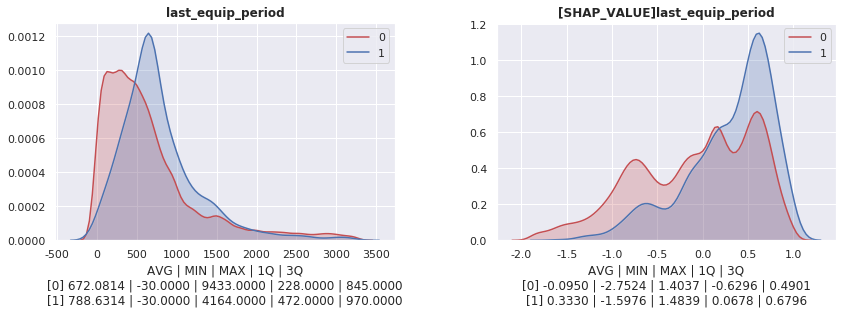

In [35]:
sm.real_vs_shap_scatter_plot('last_equip_period')

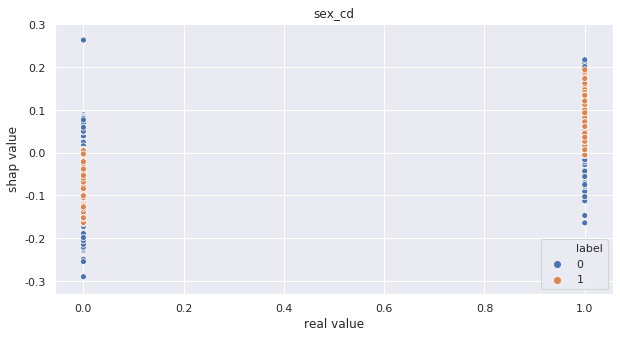

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



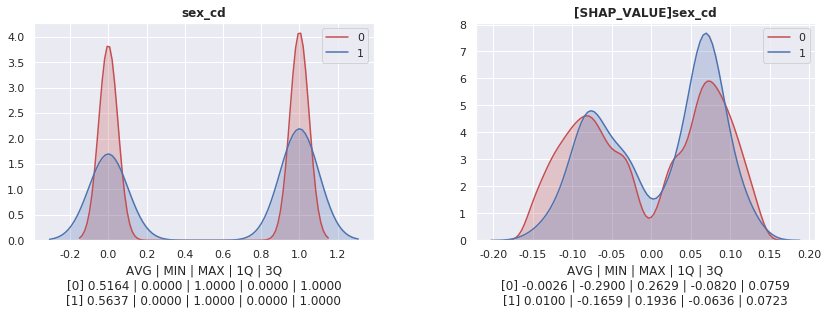

In [154]:
sm.real_vs_shap_scatter_plot('sex_cd')

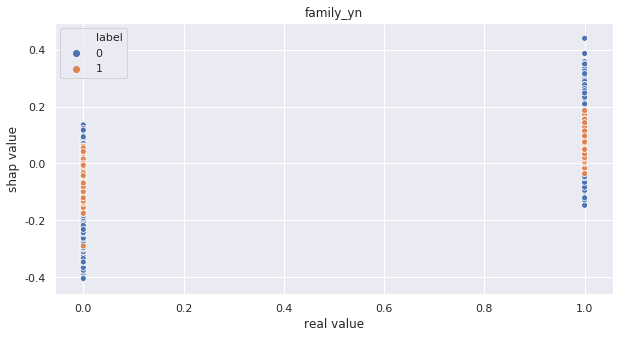

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



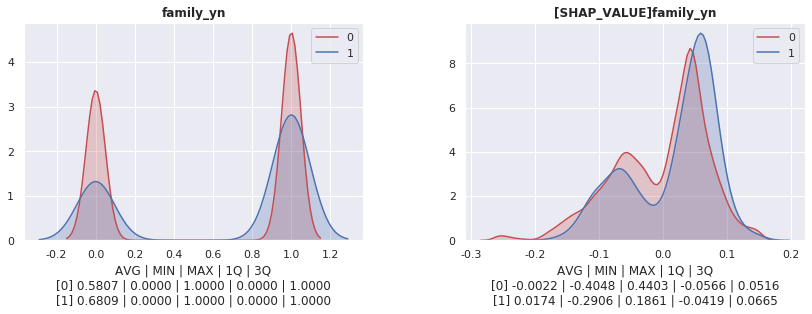

In [155]:
sm.real_vs_shap_scatter_plot('family_yn')

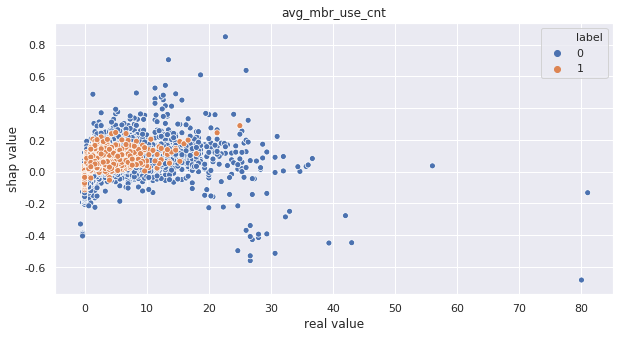

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



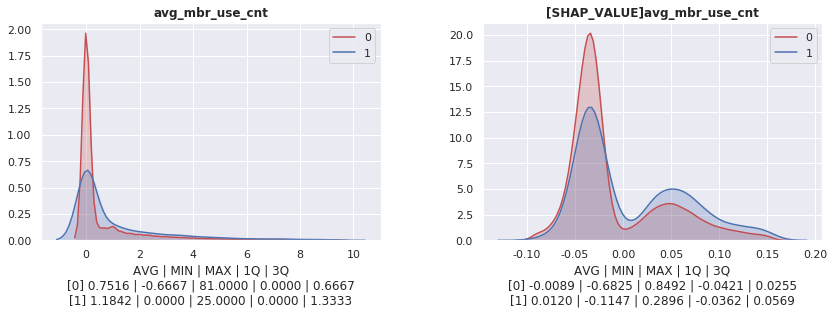

In [156]:
sm.real_vs_shap_scatter_plot('avg_mbr_use_cnt')

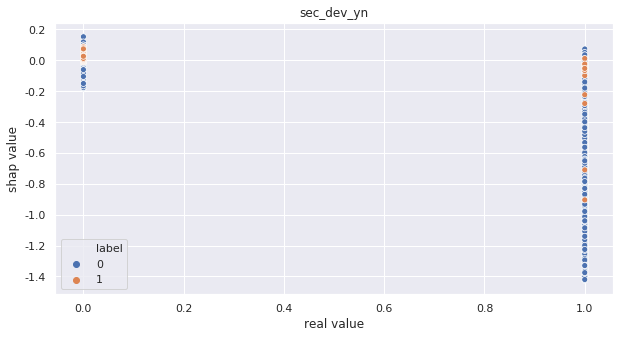

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



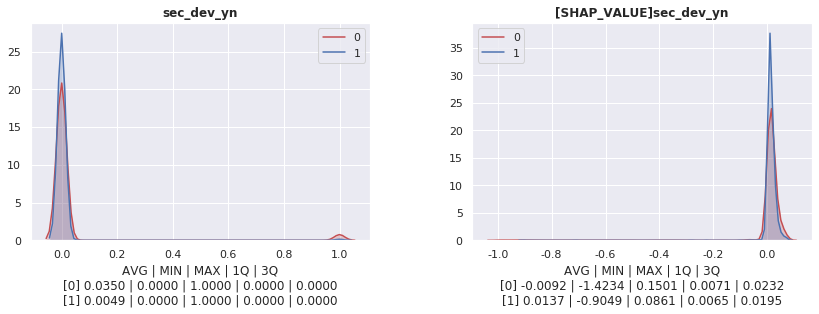

In [158]:
sm.real_vs_shap_scatter_plot('sec_dev_yn')

Confusion matrix


Pred:True  Pred:False
Actual:True           0           0
Actual:False          0           0

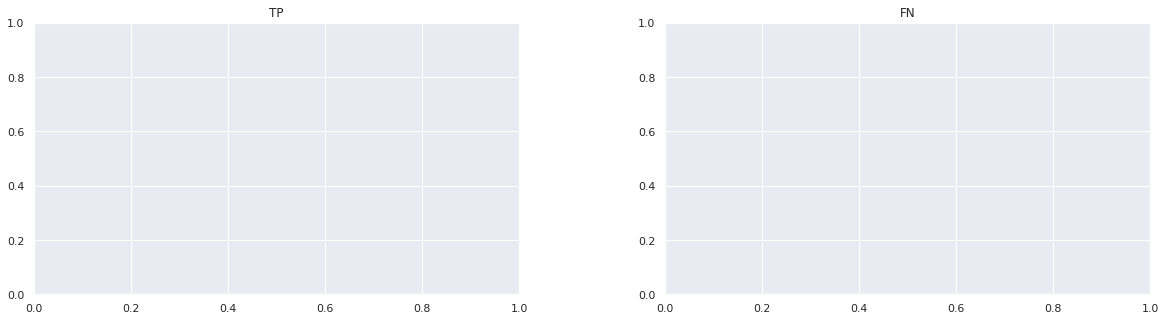

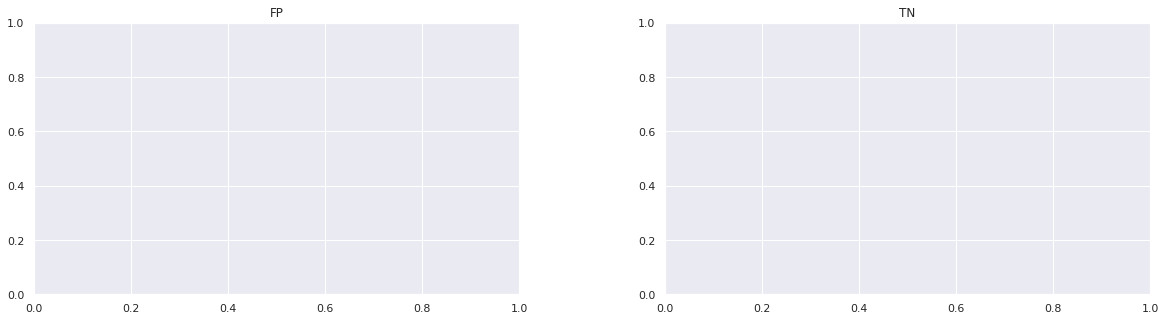

In [160]:
sm.summary_plot_for_confusion_matrix()

## 8월 데이터를 이용해서 prediction

In [173]:
df_mart08[df_mart08['data_usage_in_gb_bf_m0']==0].shape

(2569425, 80)

In [23]:
df_mart08 = pd.read_pickle('/home/dmig/work/upsell/data/df_input_201908.pkl')
df_mart08.shape

(18931654, 80)

In [26]:
df_score = df_mart08[['svc_mgmt_num']]

In [27]:
df_score['score'] = clf.predict(df_mart08[feature_cols])

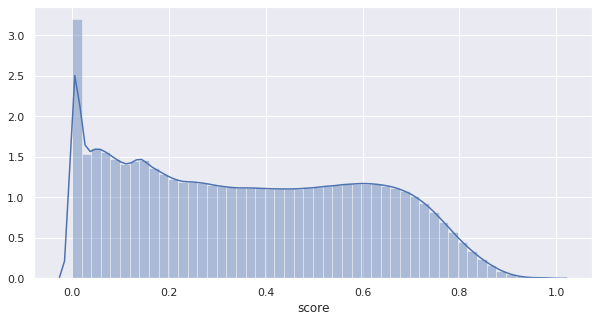

In [28]:
import seaborn as sns

sns.distplot(df_score['score'])

In [167]:
df_score['prod_id'] = 'RC00000001'
df_score['prod_nm'] = '요금제업셀가망'
df_score['score'] = np.round(df_score.score, 4)
df_score['reco_type'] = 'upsell'
df_score['model'] = 'dominic_lgbm_20190906'
df_score['dt'] = '20190906'

In [159]:
df_score.sort_values('score').head(20)

svc_mgmt_num  score     prod_id  prod_nm reco_type  \
2834    7040712978    0.0  RC00000001  요금제업셀가망    upsell   
78463   7035250518    0.0  RC00000001  요금제업셀가망    upsell   
46353   7248941857    0.0  RC00000001  요금제업셀가망    upsell   
60147   7051372031    0.0  RC00000001  요금제업셀가망    upsell   
8740    7248178084    0.0  RC00000001  요금제업셀가망    upsell   
97226   7043736382    0.0  RC00000001  요금제업셀가망    upsell   
2803    7041171364    0.0  RC00000001  요금제업셀가망    upsell   
41696   7190348893    0.0  RC00000001  요금제업셀가망    upsell   
27361   7248875467    0.0  RC00000001  요금제업셀가망    upsell   
79812   7227174688    0.0  RC00000001  요금제업셀가망    upsell   
45006   7235453640    0.0  RC00000001  요금제업셀가망    upsell   
62548   7229887426    0.0  RC00000001  요금제업셀가망    upsell   
96798   7048677718    0.0  RC00000001  요금제업셀가망    upsell   
8635    7248146588    0.0  RC00000001  요금제업셀가망    upsell   
76968   7030674782    0.0  RC00000001  요금제업셀가망    upsell   
38683   1623370110    0.0  RC00000001  요금제업셀가망    upsell   
97714   7215633309    0.0  RC00000001  요금제업셀가망    upsell   
64057   7245564564    0.0  RC00000001  요금제업셀가망    upsell   
4420    7210947915    0.0  RC00000001  요금제업셀가망    upsell   
2973    7042768785    0.0  RC00000001  요금제업셀가망    upsell   

                       model        dt  
2834   dominic_lgbm_20190709  20190905  
78463  dominic_lgbm_20190709  20190905  
46353  dominic_lgbm_20190709  20190905  
60147  dominic_lgbm_20190709  20190905  
8740   dominic_lgbm_20190709  20190905  
97226  dominic_lgbm_20190709  20190905  
2803   dominic_lgbm_20190709  20190905  
41696  dominic_lgbm_20190709  20190905  
27361  dominic_lgbm_20190709  20190905  
79812  dominic_lgbm_20190709  20190905  
45006  dominic_lgbm_20190709  20190905  
62548  dominic_lgbm_20190709  20190905  
96798  dominic_lgbm_20190709  20190905  
8635   dominic_lgbm_20190709  20190905  
76968  dominic_lgbm_20190709  20190905  
38683  dominic_lgbm_20190709  20190905  
97714  dominic_lgbm_20190709  20190905  
64057  dominic_lgbm_20190709  20190905  
4420   dominic_lgbm_20190709  20190905  
2973   dominic_lgbm_20190709  20190905

In [168]:
conn = hive_connection('dmig')
send_query(conn, 'drop table dumbo.item_reco_predict_dominic')

2019-09-06 17:41:26,435 - YE_HIVE - INFO - Query 'drop table dumbo.item_reco_predict_dominic' is done


In [169]:
conn = hive_connection('dmig')
load_to_hive(conn, 
             df_score[['svc_mgmt_num', 'prod_id', 'prod_nm', 'score', 'reco_type', 'model', 'dt']], 
             'dumbo.item_reco_predict_dominic')

2019-09-06 17:41:33,859 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_predict_dominic (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, dt string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-09-06 17:41:33,877 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-09-06 17:43:10,883 - YE_HIVE - INFO - Loading data to HDFS... 
2019-09-06 17:43:29,435 - YE_HIVE - INFO - Loading to table dumbo.item_reco_predict_dominic is done


In [170]:
insert_sql = """
INSERT  OVERWRITE TABLE comm.item_reco_predict PARTITION (reco_type, model, dt)
SELECT  *
FROM    dumbo.item_reco_predict_dominic
"""

In [165]:
from tigger.util.hive_tools import send_query

In [171]:
conn = hive_connection('dmig')
send_query(conn, insert_sql)

2019-09-06 17:46:17,664 - YE_HIVE - INFO - Query '
INSERT  OVERWRITE TABLE comm.item_reco_predict PARTITION (reco_type, model, dt)
SELECT  *
FROM    dumbo.item_reco_predict_dominic
' is done


In [162]:
save_model(clf, 'dominic_lgbm_20190709')

save model to  /home/dmig/work/upsell/model/dominic_lgbm_20190709


## Future works

## superset 사용해보기

### load model

In [5]:
input_ym = '201906'
label_ym = next_month(input_ym)

input_sql = "select * from comm.user_profile_pivot_monthly where ym='{}'".format(input_ym)
label_sql = "select * from comm.user_label_matrix_for_upsell_monthly where ym='{}'".format(label_ym)

print(input_sql)
print(label_sql)

select * from comm.user_profile_pivot_monthly where ym='201906'
select * from comm.user_label_matrix_for_upsell_monthly where ym='201907'


In [6]:
conn = hive_connection('dmig')
df_input = load_from_hive(conn, input_sql)
df_input.head()

2019-09-05 14:26:09,588 - YE_HIVE - INFO - ...tmp_db name = tmp_20190905_14_26_09_a482bce2609b95ca350cb4a843cd1964d05701ec
2019-09-05 14:26:09,590 - YE_HIVE - INFO - Start creating table
2019-09-05 14:26:09,591 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190905_14_26_09_a482bce2609b95ca350cb4a843cd1964d05701ec
2019-09-05 14:26:09,642 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190905_14_26_09_a482bce2609b95ca350cb4a843cd1964d05701ec' is done
2019-09-05 14:29:28,456 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190905_14_26_09_a482bce2609b95ca350cb4a843cd1964d05701ec 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from comm.user_profile_pivot_monthly where ym='201906'' is done
2019-09-05 14:29:28,714 - YE_HIVE - INFO - Elapsed Time = 199.12
2019-09-05 14:29:28,716 

svc_mgmt_num sex_cd     age  real_avg_arpu  roaming_cnt_m3  \
0   7290553383      2     9.0        13207.8             0.0   
1   7290553679      B -7981.0        15000.0             0.0   
2   7290554605      1    65.0        25000.0             0.0   
3   7290554629      1    66.0        42000.0             0.0   
4   7290554830      2    39.0            0.0             0.0   

   last_eqp_buy_duration  tw_visit_days_fee_t_small  \
0                    0.0                        0.0   
1                    0.0                        0.0   
2                    0.0                        0.0   
3                    0.0                        0.0   
4                    0.0                        0.0   

   location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
0                          2.0                                 0.0   
1                          0.0                                 0.0   
2                         13.0                                 0.0   
3                         37.0                                 0.0   
4                          7.0                                 0.0   

   app_use_traffic_movie  ...  voc_snd_cnt_student  voc_snd_cnt_interior  \
0                    0.0  ...                  0.0                   0.0   
1                    0.0  ...                  0.0                   0.0   
2                    0.0  ...                  0.0                   0.0   
3                    0.0  ...                  0.0                   0.0   
4                    0.0  ...                  0.0                   0.0   

   voc_rvc_cnt  sms_snd_cnt_wedding  sms_rcv_cnt_interior  sms_snd_cnt_travel  \
0          0.0                  0.0                   0.0                 0.0   
1          0.0                  0.0                   0.0                 0.0   
2          0.0                  0.0                   0.0                 0.0   
3          0.0                  0.0                   0.0                 0.0   
4          0.0                  0.0                   0.0                 0.0   

  mbr_discount_cnt_insurance  voc_rcv_cnt_tax sms_snd_cnt_baby      ym  
0                        0.0              0.0              0.0  201906  
1                        0.0              0.0              0.0  201906  
2                        0.0              0.0              0.0  201906  
3                        0.0              0.0              0.0  201906  
4                        0.0              0.0              0.0  201906  

[5 rows x 415 columns]

In [7]:
df_label = load_from_hive(conn, label_sql)
df_label.head()

2019-09-05 14:39:05,907 - YE_HIVE - INFO - ...tmp_db name = tmp_20190905_14_39_05_d05f25fc9d763216958efae29ab06c99e4bf7ab1
2019-09-05 14:39:05,910 - YE_HIVE - INFO - Start creating table
2019-09-05 14:39:05,911 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190905_14_39_05_d05f25fc9d763216958efae29ab06c99e4bf7ab1
2019-09-05 14:39:05,965 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190905_14_39_05_d05f25fc9d763216958efae29ab06c99e4bf7ab1' is done
2019-09-05 14:41:12,684 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190905_14_39_05_d05f25fc9d763216958efae29ab06c99e4bf7ab1 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from comm.user_label_matrix_for_upsell_monthly where ym='201907'' is done
2019-09-05 14:41:12,930 - YE_HIVE - INFO - Elapsed Time = 127.02
2019-09-05 14:

svc_mgmt_num label af_channel training_yn      ym
0   7304969491     N       오프라인           N  201907
1   7304967554     N       오프라인           N  201907
2   7304965004     N       오프라인           N  201907
3   7304964646     N       오프라인           N  201907
4   7304964005     N       오프라인           N  201907

In [8]:
df_input.shape, df_label.shape

((19323068, 415), (19336764, 5))

In [9]:
df_mart = pd.merge(df_input, df_label[['svc_mgmt_num', 'label']], how='left', on='svc_mgmt_num')

df_mart.shape

(19323068, 416)

In [10]:
del df_input, df_label

In [11]:
import gc
gc.collect()

13225

In [12]:
df_mart.select_dtypes(include=['object']).columns

Index(['svc_mgmt_num', 'sex_cd', 'eqp_mdl_cd',
       'additional_svc_oksusu_scrb_type', 'fee_prod_id',
       'data_gift_recv_yn_bf_m2', 'filter_sex', 'copn_data_u1_yn_bf_m0',
       'svc_scrb_dt', 'channel', 'filter_svc_cd', 'fee_chg_dt',
       'filter_block_obj_cl_cd', 'rmk_omd_yn', 'op_sale_chnl_cl_cd',
       'cncl_aply_bf_equip_chg_dt', 'smartwatch_yn', 'filter_fee_prod',
       'cncl_aply_last_equip_chg_dt', 'additional_svc_allcare_scrb_type',
       'prod_nm', 'additional_svc_ansim_option_scrb_type', 'nh00000059_yn',
       'data_gift_send_yn_bf_m0', 'filter_pps', 'job_cd', 'filter_smile',
       'copn_data_u1_yn_bf_m1', 'filter_svc_st_cd', 'filter_sktemployee',
       'childwatch_yn', 'family_marriage_yn', 'nm_cust_num', 'filter_term_dt',
       'filter_svc_use_typ_cd', 'mbr_card_gr_cd', 'tablet_yn', 'filter_lte',
       'additional_svc_flo_scrb_type', 'na00002040_yn', 'filter_agree_201',
       'svc_gr_cd', 'family_yn', 'filter_tfamilymoa', 'nh00000037_yn',
       'filter_us

In [13]:
# null check
col_null_sum = df_mart.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  label    9283
dtype: int64


In [14]:
df_mart = df_mart[df_mart.label.notnull()]

In [15]:
df_mart.shape

(19313785, 416)

In [ ]:
# TODO: 나중에 zero check
# for col in df_mart.select_dtypes(include=['int', 'float']).columns:
#     zero_rate = df_mart[df_mart[col]==0].shape[0] /df_mart.shape[0]
#     if zero_rate > 0.95:
#         print('-'*20)
#         print('col: ', col)
#         print('zero_rate: ',zero_rate)
#         print('')

In [16]:
# only one value check
for col in df_mart.select_dtypes(include=['int', 'float']).columns:
    if df_mart[col].nunique() == 1:
        print('-'*20)
        print('col: ', col)
        print('value: ', df_mart[col].unique())
        print('')

--------------------
col:  eqp_out_prc
value:  [0.]

--------------------
col:  card_pay_cnt_bf_m1
value:  [0.]

--------------------
col:  voc_rvc_cnt
value:  [0.]



In [17]:
df_mart.drop(['eqp_out_prc', 'card_pay_cnt_bf_m1', 'voc_rvc_cnt'], axis=1, inplace=True)

In [19]:
filter_cols = [c for c in df_mart.columns if 'filter_' in c]
yn_cols = [ c for c in df_mart.columns if 'yn' in c]
dt_cols = [c for c in df_mart.columns if '_dt' in c]

In [22]:
dt_cols

['svc_scrb_dt',
 'fee_chg_dt',
 'cncl_aply_bf_equip_chg_dt',
 'cncl_aply_last_equip_chg_dt',
 'filter_term_dt',
 'scrb_sta_dt',
 'cust_birth_dt']

In [23]:
del_cols = ['rmk_omd_yn', 'sec_dev_yn', 't_agr_t_eqpal_scrb_yn']
del_cols += ['filter_svc_cd', 'filter_sktemployee', 'filter_term_dt', 'filter_agree_201', 'filter_agree_203', 'filter_five_g']
del_cols += ['scrb_sta_dt', 'cust_birth_dt', 'cncl_aply_bf_equip_chg_dt']
df_mart.drop(del_cols, axis=1, inplace=True)
df_mart = df_mart[df_mart['fee_chg_dt'] != 'N/A'] 

In [24]:
dt_cols = [c for c in df_mart.columns if '_dt' in c]
dt_cols

['svc_scrb_dt', 'fee_chg_dt', 'cncl_aply_last_equip_chg_dt']

In [26]:
for c in dt_cols:
    print('c: ', c)
    new_c = 'days_from_{}'.format(c)
    df_mart[c] = df_mart[c].apply(lambda x: '2020-09-02' if x == '99991231' else x)
    df_mart['delta'] = datetime.now() - pd.to_datetime(df_mart[c])
    df_mart[new_c] = df_mart['delta'].apply(lambda x: x.days)

c:  svc_scrb_dt
c:  fee_chg_dt
c:  cncl_aply_last_equip_chg_dt


In [27]:
df_mart.drop(['delta', 'svc_scrb_dt', 'fee_chg_dt', 'cncl_aply_last_equip_chg_dt'], axis=1, inplace=True)

In [28]:
filter_cols = [c for c in df_mart.columns if 'filter_' in c]
yn_cols = [ c for c in df_mart.columns if 'yn' in c]
dt_cols = [c for c in df_mart.columns if '_dt' in c]

In [29]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [30]:
cat_cols = list(df_mart.select_dtypes(include=['object']).columns)

In [31]:
cat_cols.remove('svc_mgmt_num')
cat_cols.remove('ym')

In [32]:
# label encodinng
d = defaultdict(LabelEncoder)
df_mart[cat_cols] = df_mart[cat_cols].apply(lambda x: d[x.name].fit_transform(x))

In [33]:
df_mart.to_pickle(os.path.join(DATA_PATH, 'df_mart_superset_201906.pkl'))

In [6]:
df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_superset_201906.pkl'))

In [7]:
idx_col = 'svc_mgmt_num'

In [ ]:
df_mart_new = df_mart[~df_mart['svc_mgmt_num'].isin(filter06)]

In [ ]:
# make train data
result = make_train_data(df_mart)

trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']

val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

feature_cols = list(x_trn.columns)

lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

make_train_data +++


In [ ]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'num_threads': 40,
}

In [ ]:
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=5000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)